<a href="https://colab.research.google.com/github/shikharkyadesultory/GNN_resilient_network/blob/main/ARMA_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [2]:
!pip install torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=b42ef764a754f1e4dfc592bc2a2cc79f1ff55e8152ddba223f9bb87aaface2f7
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch_scatter


#**Functionals**

In [3]:
import torch
import torch.nn as nn

def LSIGF(h, S, x, b=None):
  F = h.shape[0] ##out features
  E = h.shape[1] ## edge features
  K = h.shape[2] ## inverse polynomial order
  G = h.shape[3] ## input features
  assert S.shape[0] == E
  N = S.shape[1]
  assert S.shape[2] == N
  B = x.shape[0]
  assert x.shape[1] == G
  assert x.shape[2] == N

  x = x.reshape([B, 1, G, N])
  S = S.reshape([1, E, N, N])
  z = x.reshape([B, 1, 1, G, N]).repeat([1, E, 1, 1, 1])
  for k in range(1,K):
    x = torch.matmul(x,S)
    xS = x.reshape([B, E, 1, G, N])
    z = torch.cat((z,xS),dim=2)
  y = torch.matmul(z.permute(0,4,1,2,3).reshape([B,N,E*K*G]),
                   h.reshape([F, E*K*G]).permute(1,0)).permute(0,2,1)
  if b is not None:
    y = y + b.reshape([1, F, 1])
  return y

def jARMA(psi, varphi, phi, S, x, b=None, tMax=5):
    dtype = x.dtype
    device = x.device

    psi = psi.to(dtype).to(device)
    varphi = varphi.to(dtype).to(device)
    phi = phi.to(dtype).to(device)
    S = S.to(dtype).to(device)
    F = psi.shape[0]  # out features = 64
    E = psi.shape[1]  # edge features = 1
    P = psi.shape[2]  # inverse polynomial order = 2
    G = psi.shape[3]  # input features = 8

    assert varphi.shape[0] == F
    assert varphi.shape[1] == E
    assert varphi.shape[2] == P
    assert varphi.shape[3] == G
    assert phi.shape[0] == F
    assert phi.shape[1] == E
    assert phi.shape[3] == G

    B = x.shape[0]  # batch size = 1
    assert x.shape[1] == G  # 8
    N = x.shape[2]  # number of nodes = 200
    assert S.shape[0] == E  # 1
    assert S.shape[1] == S.shape[2] == N  # 200

    ## Making the Stilde and Sbar
    Stilde = torch.empty(0).to(S.device)
    DiagS = torch.empty(0).to(S.device)

    for e in range(E):
        thisS = torch.index_select(S, 0, torch.tensor(e).to(S.device)).squeeze(0)
        thisDiagS = torch.diag(torch.diag(thisS))
        DiagOffS = (thisS - thisDiagS).unsqueeze(0)
        Stilde = torch.cat((Stilde, DiagOffS), dim=0)
        DiagS = torch.cat((DiagS, thisDiagS.unsqueeze(0)), dim=0)

    I = torch.eye(N).reshape([1, 1, 1, 1, N, N]).to(S.device)
    psiI = psi.reshape([F, E, P, G, 1, 1]) * I
    DiagS = DiagS.reshape([1, E, 1, 1, N, N])
    Sbar = DiagS - psiI

    # Handle numerical stability for SbarInv
    offDiagonalOnes = (torch.ones(N, N) - torch.eye(N)).to(Sbar.device)
    Sbar_safe = Sbar + offDiagonalOnes

    # Compute inverse only for diagonal elements
    eye_mask = torch.eye(N).bool().to(Sbar.device)
    SbarInv = torch.zeros_like(Sbar_safe, dtype=dtype, device=device)

    for f in range(F):
        for e in range(E):
            for p in range(P):
                for g in range(G):
                    Sbar_diag = Sbar_safe[f, e, p, g]
                    inv_diag = torch.where(eye_mask, 1.0 / Sbar_diag, torch.eye(N, dtype=dtype,device=device))
                    SbarInv[f, e, p, g] = inv_diag

    SbarInvX = torch.matmul(SbarInv.reshape([1, F, E, P, G, N, N]),
                          x.reshape([B, 1, 1, 1, G, N, 1])).squeeze(6)

    SbarInvStilde = torch.matmul(SbarInv, Stilde.reshape([1, E, 1, 1, N, N]))
    H3x = LSIGF(phi, S, x)

    ## Combining all the filters
    z = SbarInvX.reshape([B, F, E, 1, P, G, N])
    y = x.reshape([B, 1, 1, 1, G, N, 1])
    x1 = SbarInvX.unsqueeze(6)

    for tau in range(1, tMax+1):
        x1 = torch.matmul(SbarInvStilde.unsqueeze(0), x1)
        z = torch.cat((z, x1.squeeze(6).unsqueeze(3)), dim=3)
        y = torch.matmul(SbarInvStilde.unsqueeze(0), y)

    thisCoeff = torch.tensor([(-1.)**k for k in range(tMax + 1)], device=x.device, dtype=x.dtype)
    thisCoeff = thisCoeff.reshape([1, 1, 1, tMax + 1, 1])
    varphi_expanded = varphi.unsqueeze(3)  # [64, 1, 2, 1, 8]
    varphi_expanded = varphi_expanded.expand(-1, -1, -1, tMax + 1, -1)  # [64, 1, 2, 6, 8]

    thisCoeff = thisCoeff.expand(F, E, P, -1, G)  # [64, 1, 2, 6, 8]
    thisCoeff = thisCoeff * varphi_expanded
    z = z.permute(0, 6, 1, 2, 3, 4, 5)
    z_flat = z.reshape(B, N, -1)
    thisCoeff_flat = thisCoeff.permute(1, 2, 3, 4, 0)  # [1, 2, 6, 8, 64]
    thisCoeff_flat = thisCoeff_flat.reshape(-1, F)

    thisCoeff_flat = thisCoeff_flat.repeat_interleave(F, dim=0)  # [6144, 64]

    # Now matrix multiplication: [1, 200, 6144] @ [6144, 64] = [1, 200, 64]
    H1x = torch.matmul(z_flat, thisCoeff_flat)  # [1, 200, 64]
    H1x = H1x.permute(0, 2, 1)  # [1, 64, 200]

    # Compute H2x
    y = torch.matmul(SbarInvStilde.unsqueeze(0), y).squeeze(6)  # [1, 64, 1, 2, 8, 200]
    H2x = -y if (tMax % 2 == 0) else y
    H2x = torch.sum(H2x, dim=(2, 3, 4))  # Sum over E, P, G: [1, 64, 200]

    u = H1x + H2x + H3x  # [1, 64, 200]

    if b is not None:
        u = u + b.reshape([1, F, 1])  # [1, 64, 1]

    return u
import math
class GraphFilterARMA(nn.Module):
  def __init__(self,G,F,P,K,E=1,bias=True,tMax = 5):
    super().__init__() ##initializing the parent
    self.G = G
    self.F = F
    self.P = P
    self.K = K
    self.E = E
    self.tMax = tMax
    self.S = None ## GSO to be assigned lateron
    self.N = None

    # Creation of Parameters
    self.inverseWeight = nn.parameter.Parameter(torch.Tensor(F,E,P,G))
    self.directWeight  = nn.parameter.Parameter(torch.Tensor(F,E,P,G))
    self.filterWeight  = nn.parameter.Parameter(torch.Tensor(F,E,K,G))
    if bias:
      self.bias = nn.parameter.Parameter(torch.Tensor(F,1))
    else:
      self.register_parameter('bias',None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.G * self.P)
    self.inverseWeight.data.uniform_(1.+1./stdv, 1.+2./stdv)
    self.directWeight.data.uniform_(-stdv,stdv)
    self.filterWeight.data.uniform_(-stdv,stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv,stdv)

  def addGSO(self,S):
    assert len(S.shape) == 3
    assert S.shape[0] == self.E
    self.N = S.shape[1]
    assert S.shape[2] == self.N
    self.S = S

  def forward(self,x):
    B = x.shape[0]
    F = x.shape[1]
    Nin = x.shape[2]
    ## adding zero padding
    if Nin < self.N:
      x = torch.cat((x , torch.zeros(B,F,self.N-Nin).type(x.dtype).to(x.device)),dim = 2)
    u = jARMA(self.inverseWeight,self.directWeight,self.filterWeight,self.S, x, b = self.bias, tMax=self.tMax)
    if Nin < self.N:
      u = torch.index_select(u, 2, torch.arange(Nin).to(u.device)) ## removing the unnecessary padding
    return u

  def extra_repr(self):
    repString += "in features=%d" % self.G
    repString += "out features=%d" % self.F
    repString += "denominator taps=%d" % self.P
    repString += "residue taps=%d" % self.K
    repString += "edge Features=%d"% self.E
    repString += "bias=%r" % (self.bias is not None)
    if self.S is not None:
      repString += "GSO stored"
    else:
      repString += "GSO not stored"
    return repString

## Graph Tools ##
import torch
import torch.nn as nn
import numpy as np
## perm identity ##
def permIdentity(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0], S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False
  N = S.shape[1]
  order = np.arange(N)
  if scalarWeights:
    S = S.reshape([N, N])
  return S, order.tolist()

def permDegree(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  scalarWeights = False
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0], S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False

  d = np.sum(np.sum(S, axis=1),axis = 0) ## computing the degree
  order = np.argsort(d)
  order = np.flip(order,0)
  S = S[:,order,:][:,:,order]
  if scalarWeights:
    S = S.reshape([S.shape[1],S.shape[2]])
  return S,order.tolist()

def changeDataType(x, dataType):
  if 'dtype' in dir(x):
    varType = x.dtype
  if 'numpy' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.cpu().numpy().astype(dataType)
    elif 'numpy'in repr(type(x)):
      x = x.astype(dataType)
  elif 'torch' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.type(dataType)
    elif 'numpy' in repr(type(x)):
      x = torch.tensor(x, dtype = dataType)
  return x

class AveragePooling(nn.Module):
    def __init__(self, n_in, n_out, alpha):
        super().__init__()
        self.alpha = alpha
        self.n_in = n_in
        self.n_out = n_out

    def forward(self, x):
        return torch.mean(x, dim=-1, keepdim=True)

In [4]:
class ARMAfilterGNN(nn.Module):
  def __init__(self, dimNodeSignals, nDenominatorTaps, nResidueTaps, bias,
            nonlinearity, nSelectedNodes, poolingFunction, poolingSize,
            dimLayersMLP=None, GSO=None, order=None, dimLayerIPR=None, tMax=5):
    print("Initializing the ARMAfilter GNN ...")
    try:
      super().__init__()
      assert len(dimNodeSignals) == len(nDenominatorTaps) + 1
      assert len(dimNodeSignals) == len(nResidueTaps) + 1
      assert len(nSelectedNodes) == len(nResidueTaps)
      assert len(poolingSize) == len(nResidueTaps)
      assert len(GSO.shape) == 2 or len(GSO.shape) == 3
      print("all the assertions passed")
      if len(GSO.shape) == 2:
        assert GSO.shape[0] == GSO.shape[1]
        GSO = GSO.reshape([1, GSO.shape[0], GSO.shape[1]])
      else:
        assert GSO.shape[1] == GSO.shape[2]
      self.L = len(nResidueTaps)
      self.F = dimNodeSignals
      self.P = nDenominatorTaps
      self.K = nResidueTaps
      self.E = GSO.shape[0]
      self.N = [GSO.shape[1] ] + nSelectedNodes
      self.bias = bias
      if order is not None:
        self.permFunction = eval('perm' + order)
      else:
        self.permFunction = permIdentity
      self.S, self.order = self.permFunction(GSO)
      self.S = torch.tensor(self.S, dtype=torch.float32)
      self.sigma = nonlinearity
      self.alpha = poolingSize
      self.dimLayersMLP = dimLayersMLP if dimLayersMLP is not None else []
      self.dimLayerIPR = dimLayerIPR if dimLayerIPR is not None else []
      self.tMax = tMax

      # def average_pooling(n_in, n_out, alpha):
          # return AveragePooling(n_in, n_out, alpha)

      self.rho = AveragePooling
      self.readout = nn.AdaptiveAvgPool1d(1)
      gfl = []
      for l in range(self.L):
        gfl.append(GraphFilterARMA(self.F[l], self.F[l+1], self.P[l], self.K[l], self.E, self.bias, self.tMax))
        gfl[-1].addGSO(self.S)
        gfl.append(self.sigma())
        gfl.append(self.rho(n_in=self.N[l], n_out=self.N[l+1], alpha=self.alpha[l]))
      self.jARMA = nn.Sequential(*gfl)
      test_input = torch.randn(1, self.F[0], self.N[0])
      test_output = self.jARMA(test_input)
      fc = []
      if len(self.dimLayersMLP) > 0:
        # dimInputMLP = self.N[-1] * self.F[-1]
        dimInputMLP = test_output.shape[1] * test_output.shape[2]
        fc.append(nn.Linear(dimInputMLP, self.dimLayersMLP[0], bias=self.bias))
        for l in range(len(dimLayersMLP) - 1):
          fc.append(nn.Linear(dimLayersMLP[l], dimLayersMLP[l+1], bias=self.bias))
          if l < len(self.dimLayersMLP) - 2:
            fc.append(self.sigma())
      self.MLP = nn.Sequential(*fc)

      ipr_layers = []
      if len(ipr_layers) > 0:
        ipr_input_dim = self.dimLayersMLP[-1] if self.dimLayersMLP else self.F[-1]
        ipr_layers.append(nn.Linear(ipr_input_dim,self.dimLayersMLP[0], bias=self.bias))
        ipr_layers.append(self.sigma())
        for l in range(len(self.dimLayersMLP) - 1):
          ipr_layers.append(nn.Linear(self.dimLayersMLP[l], self.dimLayersMLP[l+1], bias=self.bias))
          if l < len(self.dimLayersMLP) - 2:
            ipr_layers.append(self.sigma())
        ipr_layers.append(nn.Linear(self.dimLayersMLP[-1], 1, bias=self.bias))
      else:
        ipr_input_dim = self.dimLayersMLP[-1] if dimLayersMLP else self.F[-1]
        ipr_layers.append(nn.Linear(ipr_input_dim, 1, bias=self.bias))
      self.IPR_Regressor = nn.Sequential(*ipr_layers)
      print("ARMAfilterGNN __init__ completed successfully")

    except Exception as e:
      print(f"Error during ARMAfilterGNN initialization: {e}")
      raise

  def changeGSO(self, GSO, nSelectedNodes= [], poolingSize=[]):
    assert len(GSO.shape) == 2 or len(GSO.shape) == 3
    if len(GSO.shape) == 2:
      assert GSO.shape[0] == GSO.shape[1]
      GSO = GSO.reshape([1, GSO.shape[0], GSO.shape[1]])
    else:
      assert GSO.shape[1] == GSO.shape[2]
    dataType = self.S.dataType
    if 'device' in dir(self.S):
      device = self.S.device
    else:
      device = None
    self.S, self.order = self.permFunction(GSO)
    self.S = changeDataType(self.S, dtype=torch.float32)
    if device is not None:
      self.S = self.S.to(device)
    if len(poolingSize) > 0:
      assert len(poolingSize) == self.L
      self.alpha = poolingSize
    if len(nSelectedNodes) > 0:
      assert len(nSelectedNodes) == self.L
      self.N = [GSO.shape[1] ] + nSelectedNodes
      for l in range(self.L):
        self.jARMA[3*l+2] = self.rho(self.N[l], self.N[l+1],self.alpha[l])

    else:
      for l in range(self.L):
        # self.jARMA[3*l+2].addGSO(self.S)
        pass
  def splitForward(self,x):
    assert len(x.shape) == 3
    batchSize = x.shape[0]
    assert x.shape[1] == self.F[0]
    assert x.shape[2] == self.N[0]
    if self.S is not None:
      x = x[:,:,self.order]
    y = self.jARMA(x)
    y_pooled = self.readout(y)
    y_pooled = y_pooled.squeeze(-1)
    mlp_output = self.MLP(y_pooled) if self.dimLayersMLP else y_pooled
    ipr_output = self.IPR_Regressor(mlp_output)
    return mlp_output, ipr_output.squeeze()
  def forward(self, x):
      cls_output, ipr_output = self.splitForward(x)  # Unpack both outputs
      return cls_output, ipr_output  # Return both

  def to(self, device):
      super().to(device)
      self.S = self.S.to(device)
      if self.S is not None:
        self.S = self.S.to(device)
      for l in range(self.L):
          self.jARMA[3*l].addGSO(self.S)
      return self
          # self.jARMA[3*l+2].addGSO(self.S)

In [5]:
def train_arma_model(model, train_loader, val_loader, optimizer, criterion_cls, criterion_ipr,
                    epochs=100, device='cpu', cls_weight=1.0, ipr_weight=1.0):

    train_losses = {'total': [], 'cls': [], 'ipr': []}
    val_losses = {'total': [], 'cls': [], 'ipr': []}
    val_accuracies = []
    val_ipr_errors = []

    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss_cls, epoch_train_loss_ipr = 0.0, 0.0

        for data, labels, ipr_targets in train_loader:
            data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)

            optimizer.zero_grad()

            # Forward pass (returns both classification and IPR outputs)
            cls_output, ipr_output = model(data)

            # Calculate both losses
            loss_cls = criterion_cls(cls_output, labels)
            loss_ipr = criterion_ipr(ipr_output, ipr_targets)

            # Weighted total loss
            total_loss = cls_weight * loss_cls + ipr_weight * loss_ipr

            total_loss.backward()
            optimizer.step()

            epoch_train_loss_cls += loss_cls.item()
            epoch_train_loss_ipr += loss_ipr.item()

        # Validation phase
        model.eval()
        epoch_val_loss_cls, epoch_val_loss_ipr = 0.0, 0.0
        correct, total = 0, 0
        ipr_errors = []

        with torch.no_grad():
            for data, labels, ipr_targets in val_loader:
                data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)

                cls_output, ipr_output = model(data)

                # Loss calculation
                loss_cls = criterion_cls(cls_output, labels)
                loss_ipr = criterion_ipr(ipr_output, ipr_targets)

                epoch_val_loss_cls += loss_cls.item()
                epoch_val_loss_ipr += loss_ipr.item()

                # Classification accuracy
                _, predicted = torch.max(cls_output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # IPR errors
                ipr_errors.extend(torch.abs(ipr_output - ipr_targets).cpu().numpy())

        # Record metrics
        train_losses['cls'].append(epoch_train_loss_cls / len(train_loader))
        train_losses['ipr'].append(epoch_train_loss_ipr / len(train_loader))
        train_losses['total'].append((epoch_train_loss_cls + epoch_train_loss_ipr) / len(train_loader))

        val_losses['cls'].append(epoch_val_loss_cls / len(val_loader))
        val_losses['ipr'].append(epoch_val_loss_ipr / len(val_loader))
        val_losses['total'].append((epoch_val_loss_cls + epoch_val_loss_ipr) / len(val_loader))

        val_accuracies.append(100 * correct / total)
        val_ipr_errors.append(np.mean(ipr_errors))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: '
                  f'Train Loss: {train_losses["total"][-1]:.4f} '
                  f'(Cls: {train_losses["cls"][-1]:.4f}, IPR: {train_losses["ipr"][-1]:.4f}) | '
                  f'Val Acc: {val_accuracies[-1]:.2f}% | '
                  f'Val IPR MAE: {val_ipr_errors[-1]:.4f}')

    return train_losses, val_losses, val_accuracies, val_ipr_errors

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

def evaluate_arma_model(model, test_loader, device='cpu'):
    """
    Evaluate ARMA model performance on test data

    Returns comprehensive metrics for both classification and IPR regression
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_ipr_preds = []
    all_ipr_actuals = []
    all_cls_probs = []

    with torch.no_grad():
        for data, labels, ipr_targets in test_loader:
            data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)

            cls_output, ipr_output = model(data)

            # Classification predictions
            probs = torch.softmax(cls_output, dim=1)
            _, preds = torch.max(cls_output, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_cls_probs.extend(probs.cpu().numpy())

            # IPR predictions
            all_ipr_preds.extend(ipr_output.cpu().numpy())
            all_ipr_actuals.extend(ipr_targets.cpu().numpy())

    # Convert to numpy arrays
    all_ipr_preds = np.array(all_ipr_preds)
    all_ipr_actuals = np.array(all_ipr_actuals)

    # Classification metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # IPR regression metrics
    ipr_mae = mean_absolute_error(all_ipr_actuals, all_ipr_preds)
    ipr_rmse = np.sqrt(mean_squared_error(all_ipr_actuals, all_ipr_preds))
    ipr_r2 = r2_score(all_ipr_actuals, all_ipr_preds)
    ipr_corr = np.corrcoef(all_ipr_actuals, all_ipr_preds)[0, 1]

    return {
        # Classification results
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_cls_probs,

        # IPR regression results
        'ipr_predictions': all_ipr_preds,
        'ipr_actuals': all_ipr_actuals,
        'ipr_mae': ipr_mae,
        'ipr_rmse': ipr_rmse,
        'ipr_r2': ipr_r2,
        'ipr_correlation': ipr_corr,

        # Combined metrics
        'total_samples': len(all_labels)
    }

In [ ]:
def create_star_network(n_nodes, center_weight=1.0, edge_weight=0.5):
  S = np.zeros((n_nodes,n_nodes))
  center_node = 0
  for i in range(1,n_nodes):
    S[center_node, i] = edge_weight
    S[i, center_node] = edge_weight
  np.fill_diagonal(S, center_weight)
  return S
#### Synthetic DataSet for the star network ####
from torch_geometric.data import Dataset
class StarNetworkDataset(Dataset):
  def __init__(self,n_samples=1000, n_nodes=10, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_star_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = [] # Store IPR targets

    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      features[:,0] += np.random.choice([-2,2], size=n_features)
      label = int(np.mean(features[:,0]) > 0)

      # Calculate IPR target
      node_features_for_ipr = features[0] # Using the first feature dimension for IPR calculation
      squared = np.abs(node_features_for_ipr) ** 2
      numerator = np.sum(squared ** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numerator / denominator if denominator != 0 else 0.0 # Handle division by zero

      self.data.append(torch.tensor(features, dtype=torch.float32))
      self.labels.append(label)
      self.ipr_targets.append(ipr_value) # Append IPR target

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float32) # Return all three


Using device: cpu
Initializing the ARMAfilter GNN ...
all the assertions passed
ARMAfilterGNN __init__ completed successfully
Model parameters: 30,561
Training ARMA model...
Epoch   0: Train Loss: 1.8504 (Cls: 1.8142, IPR: 0.0362) | Val Acc: 85.33% | Val IPR MAE: 0.1493
Epoch  10: Train Loss: 0.1191 (Cls: 0.1033, IPR: 0.0157) | Val Acc: 88.00% | Val IPR MAE: 0.0836
Epoch  20: Train Loss: 0.0325 (Cls: 0.0141, IPR: 0.0184) | Val Acc: 95.33% | Val IPR MAE: 0.0858
Epoch  30: Train Loss: 0.0202 (Cls: 0.0042, IPR: 0.0161) | Val Acc: 95.33% | Val IPR MAE: 0.1326
Epoch  40: Train Loss: 0.0204 (Cls: 0.0018, IPR: 0.0186) | Val Acc: 95.33% | Val IPR MAE: 0.1039
Epoch  50: Train Loss: 0.0128 (Cls: 0.0015, IPR: 0.0113) | Val Acc: 95.33% | Val IPR MAE: 0.0975
Epoch  60: Train Loss: 0.0174 (Cls: 0.0011, IPR: 0.0163) | Val Acc: 96.00% | Val IPR MAE: 0.0880
Epoch  70: Train Loss: 0.0114 (Cls: 0.0010, IPR: 0.0105) | Val Acc: 96.00% | Val IPR MAE: 0.0871
Epoch  80: Train Loss: 0.0103 (Cls: 0.0006, IPR: 0

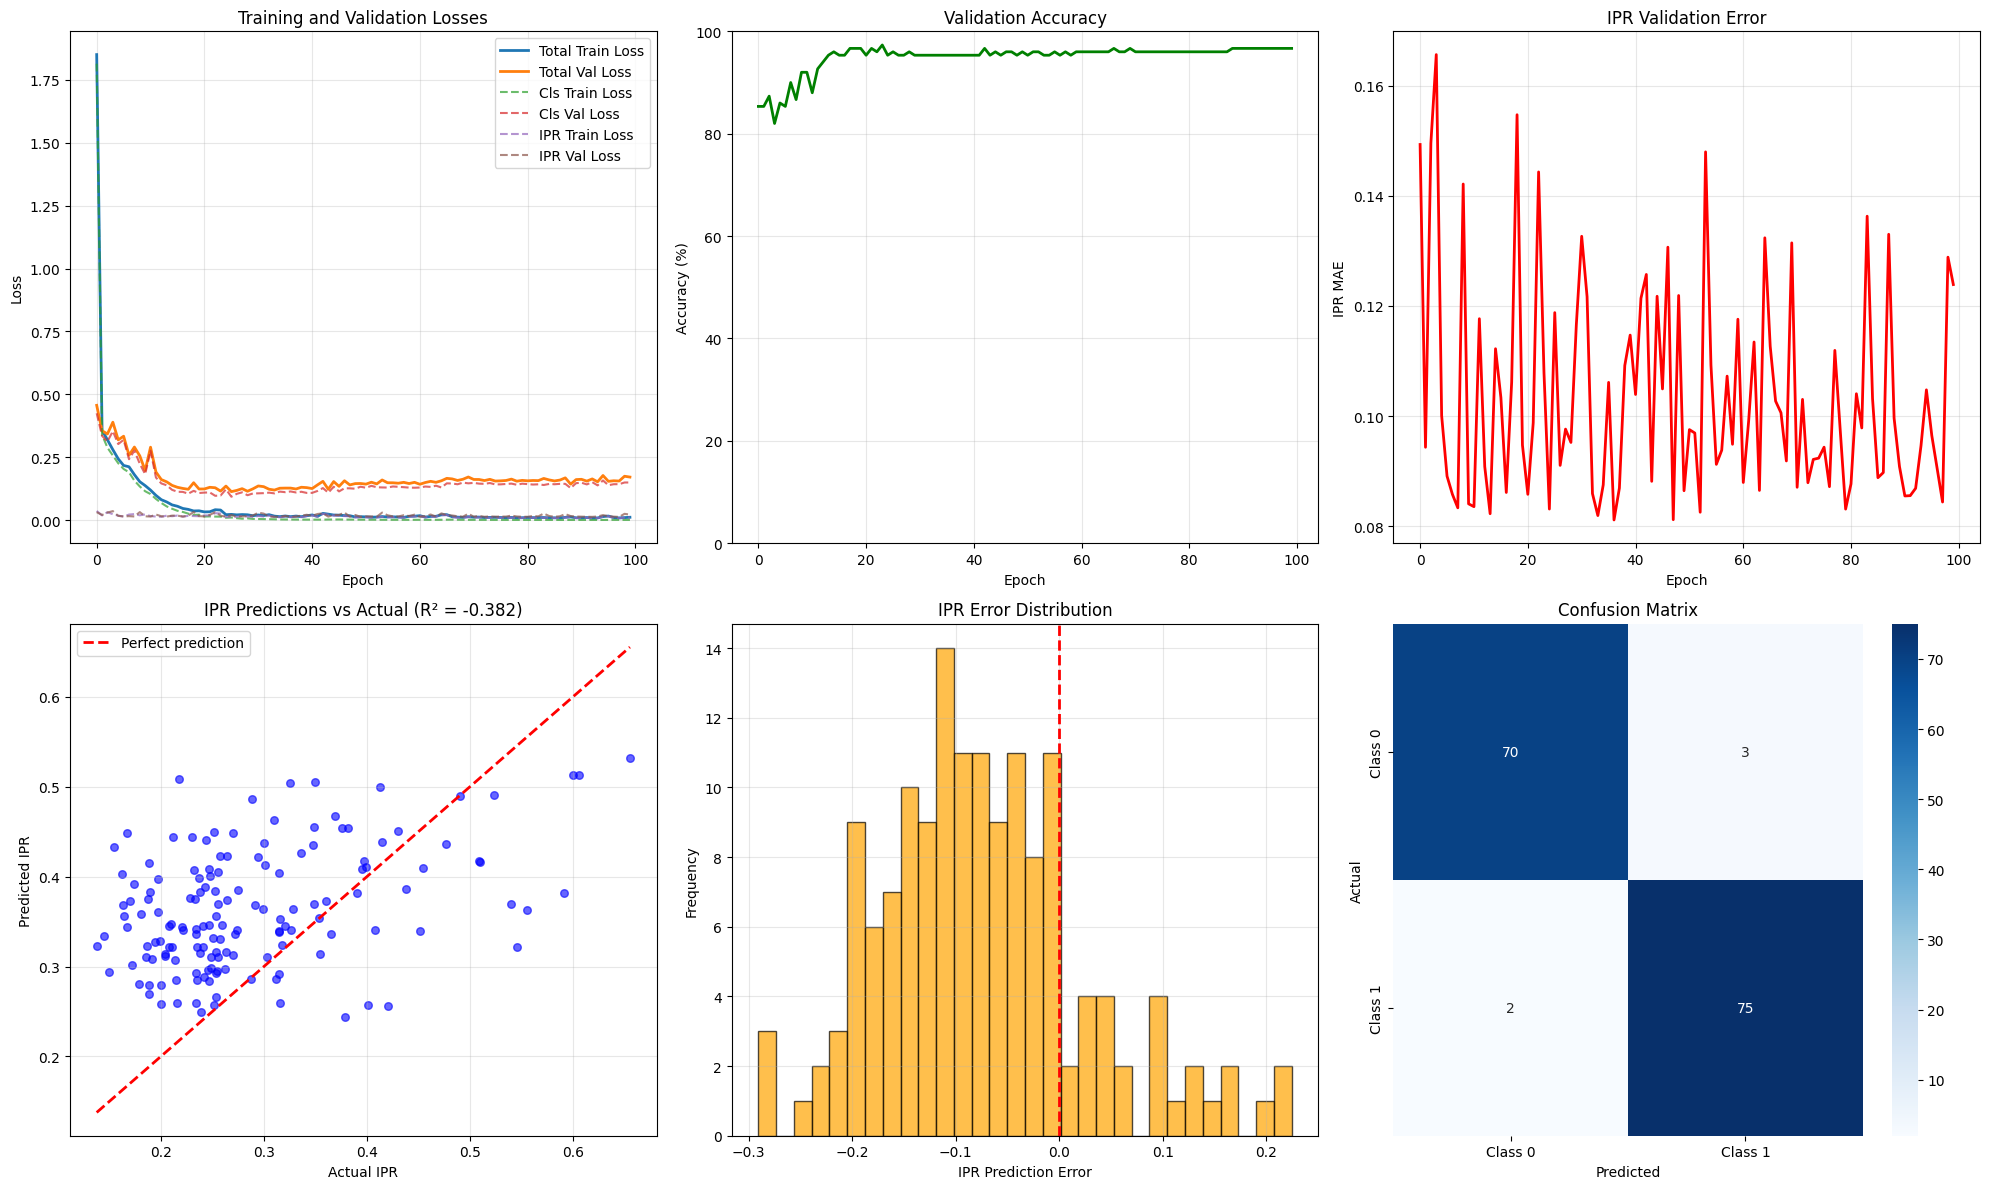


📋 DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.244, 0.532]
IPR actual range: [0.138, 0.655]
IPR error std: 0.0991

✅ Results saved to 'arma_model_results.pth'
✅ Plot saved to 'arma_model_results.png'


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

## Execution Block ##
if __name__ == "__main__":
    # Set parameters
    n_nodes = 10
    n_features = 8
    n_classes = 2
    n_samples = 1000
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create dataset (make sure it returns (data, labels, ipr_targets))
    dataset = StarNetworkDataset(n_samples=n_samples, n_nodes=n_nodes,
                               n_features=n_features, n_classes=n_classes)

    # Split dataset
    train_size = int(0.7 * n_samples)
    val_size = int(0.15 * n_samples)
    test_size = n_samples - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create adjacency matrix (star network or your preferred topology)
    adj_matrix = create_star_network(n_nodes)

    # Model configuration
    model_config = {
        'dimNodeSignals': [n_features, 64, 32],
        'nDenominatorTaps': [2, 2],
        'nResidueTaps': [3, 3],
        'bias': True,
        'nonlinearity': nn.ReLU,
        'nSelectedNodes': [100, 50],
        'poolingFunction': None,  # You need to add this parameter
        'poolingSize': [2, 2],
        'dimLayersMLP': [128, 64],
        'GSO': adj_matrix,
        'order': 'Degree',
        'dimLayerIPR': [32, 16],  # Changed to singular to match class
        'tMax': 5
    }

    # Initialize model
    model = ARMAfilterGNN(**model_config)
    model = model.to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss functions and optimizer
    criterion_cls = nn.CrossEntropyLoss()
    criterion_ipr = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the model
    print("Training ARMA model...")
    train_losses, val_losses, val_accuracies, val_ipr_errors = train_arma_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion_cls=criterion_cls,
        criterion_ipr=criterion_ipr,
        epochs=100,
        device=device,
        cls_weight=1.0,
        ipr_weight=0.8
    )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = evaluate_arma_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    # Print results
    print(f"\n{'='*50}")
    print("FINAL RESULTS")
    print(f"{'='*50}")

    print(f"\n CLASSIFICATION METRICS:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"F1 Score: {test_results['f1_score']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")

    print(f"\n IPR REGRESSION METRICS:")
    print(f"MAE: {test_results['ipr_mae']:.4f}")
    print(f"RMSE: {test_results['ipr_rmse']:.4f}")
    print(f"R² Score: {test_results['ipr_r2']:.4f}")
    print(f"Correlation: {test_results['ipr_correlation']:.4f}")

    # Generate comprehensive plots
    print("\nGenerating plots...")
    plt.figure(figsize=(20, 12))

    # Plot 1: Training and Validation Losses
    plt.subplot(2, 3, 1)
    plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
    plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
    plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
    plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
    plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
    plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Validation Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(val_accuracies, 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # Plot 3: IPR Validation Error
    plt.subplot(2, 3, 3)
    plt.plot(val_ipr_errors, 'r-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('IPR MAE')
    plt.title('IPR Validation Error')
    plt.grid(True, alpha=0.3)

    # Plot 4: IPR Predictions vs Actual (Scatter)
    plt.subplot(2, 3, 4)
    plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
                alpha=0.6, s=30, c='blue')
    min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
    max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Actual IPR')
    plt.ylabel('Predicted IPR')
    plt.title(f'IPR Predictions vs Actual (R² = {test_results["ipr_r2"]:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: IPR Error Distribution
    plt.subplot(2, 3, 5)
    ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
    plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('IPR Prediction Error')
    plt.ylabel('Frequency')
    plt.title('IPR Error Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 6: Confusion Matrix (Classification)
    plt.subplot(2, 3, 6)
    cm = confusion_matrix(test_results['labels'], test_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig('arma_model_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional detailed analysis
    print(f"\n DETAILED ANALYSIS:")
    print(f"Total samples: {test_results['total_samples']}")
    print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
    print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
    print(f"IPR error std: {np.std(ipr_errors):.4f}")

    # Save results to file
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_ipr_errors': val_ipr_errors,
        'test_results': test_results,
        'model_config': model_config
    }

    torch.save({
        'model_state_dict': model.state_dict(),
        'results': results_dict
    }, 'arma_model_results.pth')

    print(f"\n Results saved to 'arma_model_results.pth'")
    print(f" Plot saved to 'arma_model_results.png'")

#**Cirlce Network**

#**Train ARMA**

In [9]:
def train_arma_model(model, train_loader, val_loader, optimizer, criterion_cls, criterion_ipr,
                     epochs=50, device='cpu', cls_weight=1.0, ipr_weight=1.0):
  train_losses = {'total':[], 'cls':[], 'ipr':[]}
  val_losses = {'total':[], 'cls':[], 'ipr':[]}
  val_accuracies = []
  val_ipr_errors = []
  model.to(device)
  for epoch in range(epochs):

    ## Training phase ##
    model.train()
    epoch_train_loss_cls, epoch_train_loss_ipr = 0.0,0.0
    for data, labels, ipr_targets in train_loader:
      data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)
      optimizer.zero_grad()
      cls_output, ipr_output = model(data)
      loss_cls = criterion_cls(cls_output, labels) ## Cross Entropy loss
      loss_ipr = criterion_ipr(ipr_output, ipr_targets) ##MSE loss
      total_loss = cls_weight * loss_cls + ipr_weight * loss_ipr
      total_loss.backward()
      optimizer.step()
      epoch_train_loss_cls += loss_cls.item()
      epoch_train_loss_ipr += loss_ipr.item()

    ## Validation phase
    model.eval()
    epoch_val_loss_cls, epoch_val_loss_ipr = 0.0,0.0
    correct, total = 0,0
    ipr_errors = []
    with torch.no_grad():
      for data, labels, ipr_targets in val_loader:
        data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)
        cls_output, ipr_output = model(data)

        ## Loss calculaion ##
        loss_cls = criterion_cls(cls_output, labels)
        loss_ipr = criterion_ipr(ipr_output, ipr_targets)

        epoch_val_loss_cls += loss_cls.item()
        epoch_val_loss_ipr += loss_ipr.item()

        ## Classification accuracy ##
        _, predicted = torch.max(cls_output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        ## IPR Errors ##
        ipr_errors.extend(torch.abs(ipr_output - ipr_targets).cpu().numpy())
    ## Metrics for training
    train_losses['cls'].append(epoch_train_loss_cls / len(train_loader))
    train_losses['ipr'].append(epoch_train_loss_ipr / len(train_loader))
    train_losses['total'].append((epoch_train_loss_cls + epoch_train_loss_ipr) / len(train_loader))

    ## Metrics for validation
    val_losses['cls'].append(epoch_val_loss_cls / len(val_loader))
    val_losses['ipr'].append(epoch_val_loss_ipr / len(val_loader))
    val_losses['total'].append((epoch_val_loss_cls + epoch_val_loss_ipr) / len(train_loader))
    val_accuracies.append(100 * correct / total)
    val_ipr_errors.append(np.mean(ipr_errors))

    if epoch % 10 == 0:
      print(f'Epoch {epoch:3d}:'
            f'Train Loss : {train_losses["total"][-1]:.4f}'
            f'Cls{train_losses["cls"][-1]:.4f}, IPR: {train_losses["ipr"][-1]:.4f}) | '
            f'Val Acc: {val_accuracies[-1]:.2f}% | '
            f'Val IPR MAE: {val_ipr_errors[-1]:.4f}')

  return train_losses, val_losses, val_accuracies, val_ipr_errors

#**Evaluating ARMA**

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn

def evaluate_arma_model(model, test_loader, device='cpu'):
  ## Evaluating ARMA performance ##
  model.eval()

  all_preds = []
  all_labels = []
  all_ipr_preds = []
  all_ipr_actuals = []
  all_cls_probs = []
  with torch.no_grad():
    for data, labels, ipr_targets in test_loader:
      data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)
      cls_output, ipr_output = model(data)

      ## Classification predictions
      probs = torch.softmax(cls_output, dim=1)
      _, preds = torch.max(cls_output, 1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
      all_cls_probs.extend(probs.cpu().numpy())

      all_ipr_preds.extend(ipr_output.cpu().numpy())
      all_ipr_actuals.extend(ipr_targets.cpu().numpy())

  all_ipr_preds = np.array(all_ipr_preds)
  all_ipr_actuals = np.array(all_ipr_actuals)

  ## Classfication metrics ##
  accuracy = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds, average='weighted')
  precision = precision_score(all_labels, all_preds, average='weighted')
  recall  = recall_score(all_labels, all_preds, average='weighted')

  ## IPR regression
  ipr_mae = mean_absolute_error(all_ipr_actuals, all_ipr_preds)
  ipr_rmse = np.sqrt(mean_squared_error(all_ipr_actuals, all_ipr_preds))
  ipr_r2 = r2_score(all_ipr_actuals, all_ipr_preds)
  ipr_corr = np.corrcoef(all_ipr_actuals, all_ipr_preds)[0, 1]
  return {
      'accuracy': accuracy,
      'f1_score': f1,
      'precision': precision,
      'recall': recall,
      'predictions': all_preds,
      'labels': all_labels,
      'probabilities': all_cls_probs,

      'ipr_predictions': all_ipr_preds,
      'ipr_actuals': all_ipr_actuals,
      'ipr_mae': ipr_mae,
      'ipr_rmse': ipr_rmse,
      'ipr_r2': ipr_r2,
      'ipr_correlation': ipr_corr,

      'total_samples': len(all_labels)
  }

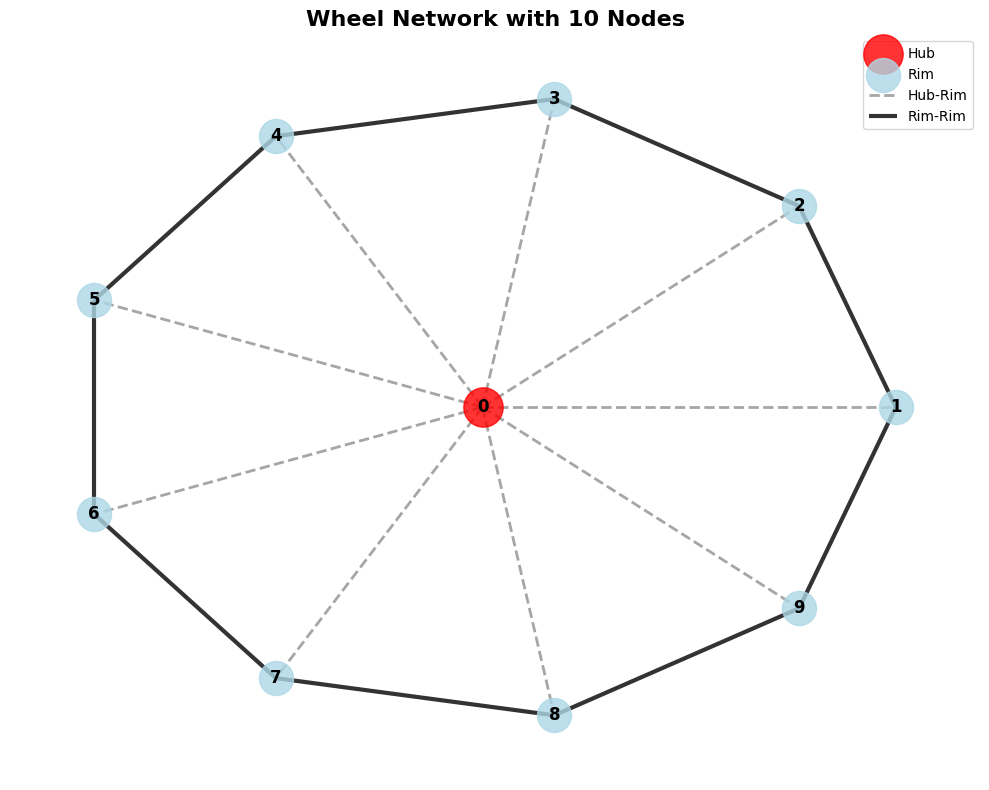

Adjacency Matrix:
[[0.5  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
 [0.75 0.5  1.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.75 1.   0.5  1.   0.   0.   0.   0.   0.   0.  ]
 [0.75 0.   1.   0.5  1.   0.   0.   0.   0.   0.  ]
 [0.75 0.   0.   1.   0.5  1.   0.   0.   0.   0.  ]
 [0.75 0.   0.   0.   1.   0.5  1.   0.   0.   0.  ]
 [0.75 0.   0.   0.   0.   1.   0.5  1.   0.   0.  ]
 [0.75 0.   0.   0.   0.   0.   1.   0.5  1.   0.  ]
 [0.75 0.   0.   0.   0.   0.   0.   1.   0.5  1.  ]
 [0.75 1.   0.   0.   0.   0.   0.   0.   1.   0.5 ]]


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def create_wheel_network(n_nodes, center_weight=1, edge_weight=0.75):
    S = np.zeros((n_nodes, n_nodes))
    rim_nodes = list(range(1, n_nodes))
    hub_idx = 0

    for i in rim_nodes:
        S[hub_idx, i] = edge_weight
        S[i, hub_idx] = edge_weight

    for i in range(len(rim_nodes)):
        current = rim_nodes[i]
        next_node = rim_nodes[(i + 1) % len(rim_nodes)]
        S[current, next_node] = center_weight
        S[next_node, current] = center_weight

    np.fill_diagonal(S, 0.5)
    return S

n_nodes = 10
adj_matrix = create_wheel_network(n_nodes)
G = nx.from_numpy_array(adj_matrix)

plt.figure(figsize=(10, 8))
pos = {}
hub_idx = 0
rim_nodes = list(range(1, n_nodes))
pos[hub_idx] = np.array([0, 0])

angles = np.linspace(0, 2 * np.pi, len(rim_nodes), endpoint=False)
for i, node in enumerate(rim_nodes):
    radius = 1.0
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    pos[node] = np.array([x, y])
hub_color = 'red'
rim_color = 'lightblue'

nx.draw_networkx_nodes(G, pos, nodelist=[hub_idx],
                       node_color=hub_color, node_size=800,
                       alpha=0.8, label='Hub')

nx.draw_networkx_nodes(G, pos, nodelist=rim_nodes,
                       node_color=rim_color, node_size=600,
                       alpha=0.8, label='Rim')

hub_rim_edges = [(hub_idx, i) for i in rim_nodes]
rim_rim_edges = [(rim_nodes[i], rim_nodes[(i + 1) % len(rim_nodes)]) for i in range(len(rim_nodes))]

nx.draw_networkx_edges(G, pos, edgelist=hub_rim_edges,
                       edge_color='gray', width=2, alpha=0.7,
                       style='dashed', label='Hub-Rim')

nx.draw_networkx_edges(G, pos, edgelist=rim_rim_edges,
                       edge_color='black', width=3, alpha=0.8,
                       label='Rim-Rim')

nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title(f"Wheel Network with {n_nodes} Nodes", fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.axis('off')
plt.tight_layout()

plt.savefig("wheel_network.png", dpi=300, bbox_inches='tight')
plt.show()

print("Adjacency Matrix:")
print(adj_matrix)

In [ ]:
from torch_geometric.data import Dataset
import numpy as np
import torch

class WheelNetworkDataset(Dataset):
  def __init__(self,n_samples=1000, n_nodes=11, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_wheel_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = []

    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      features[:, 0] += np.random.normal(2.0, 1.0, n_features)
      perimeter_nodes_to_modify = np.random.choice(np.arange(1, n_nodes), size=min(3, n_nodes - 1), replace=False) # Modify up to 3 perimeter nodes
      for node_idx in perimeter_nodes_to_modify:
          features[:, node_idx] += np.random.choice([-3, 3], size=n_features)

      ## Defining the labels based on hub and rim features ##
      hub_feature = np.mean(features[:,0])
      rim_features = np.mean(features[:,perimeter_nodes_to_modify], axis=1)
      label = int(np.abs(hub_feature - np.mean(rim_features)) > 2.0)

      ## IPR calculation setup ##
      feature_magnitudes = np.linalg.norm(features, axis=0)
      squared = feature_magnitudes ** 2
      numerator = np.sum(squared** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numerator / denominator if denominator != 0 else 0.0

      self.data.append(features)
      self.labels.append(label)
      self.ipr_targets.append(ipr_value)

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float64)

Using device: cpu
Initializing the ARMAfilter GNN ...
all the assertions passed
ARMAfilterGNN __init__ completed successfully
Model parameters: 30,561
Training ARMA model...
Epoch   0:Train Loss : 2.0131Cls1.8742, IPR: 0.1388) | Val Acc: 59.33% | Val IPR MAE: 0.2440
Epoch  10:Train Loss : 0.5601Cls0.5565, IPR: 0.0036) | Val Acc: 58.67% | Val IPR MAE: 0.0320
Epoch  20:Train Loss : 0.3722Cls0.3709, IPR: 0.0013) | Val Acc: 68.00% | Val IPR MAE: 0.0263
Epoch  30:Train Loss : 0.2224Cls0.2213, IPR: 0.0012) | Val Acc: 68.67% | Val IPR MAE: 0.0356
Epoch  40:Train Loss : 0.2225Cls0.2218, IPR: 0.0007) | Val Acc: 68.00% | Val IPR MAE: 0.0183

Evaluating on test set...

FINAL RESULTS

 CLASSIFICATION METRICS:
Accuracy: 0.7400
F1 Score: 0.7394
Precision: 0.7394
Recall: 0.7400

 IPR REGRESSION METRICS:
MAE: 0.0256
RMSE: 0.0316
R² Score: -3.2949
Correlation: 0.1285

Generating plots...


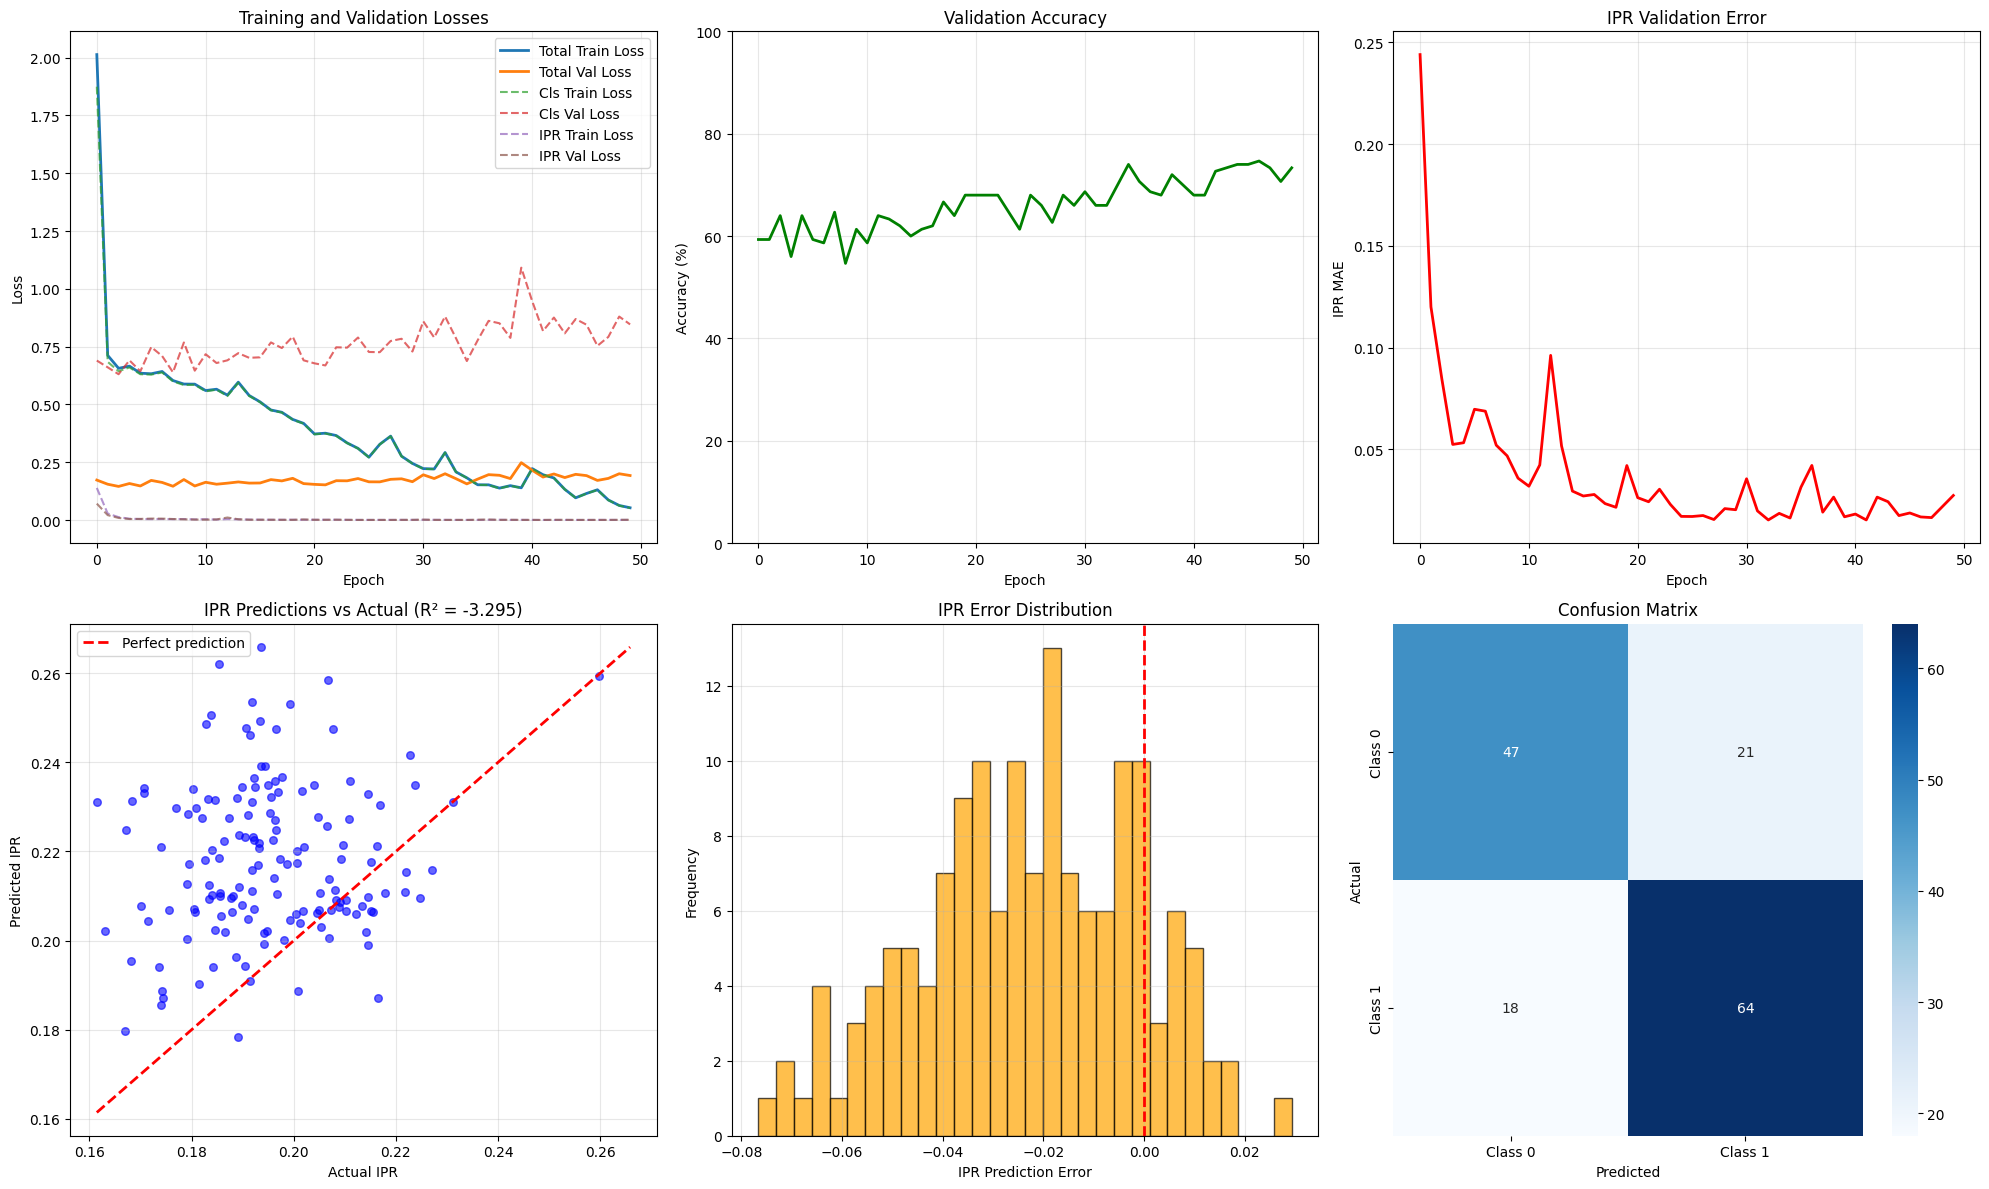


 DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.178, 0.266]
IPR actual range: [0.161, 0.260]
IPR error std: 0.0215

 Results saved to 'arma_model_Wheel_results.pth'
 Plot saved to 'arma_model_results_Wheel.png'


In [ ]:
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Execution Block ##
if __name__ == "__main__":
  n_nodes = 11
  n_features = 8
  n_classes = 2
  n_samples = 1000
  batch_size = 32
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  dataset = WheelNetworkDataset(n_samples=n_samples, n_nodes=n_nodes,
                               n_features=n_features, n_classes=n_classes)
  train_size = int(0.7 * n_samples)
  val_size = int(0.15 * n_samples)
  test_size = n_samples - train_size - val_size

  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
      dataset, [train_size, val_size, test_size]
  )

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  adj_matrix = create_wheel_network(n_nodes)
  model_config = {
    'dimNodeSignals': [n_features, 64, 32],
    'nDenominatorTaps': [2, 2],
    'nResidueTaps': [3, 3],
    'bias': True,
    'nonlinearity': nn.ReLU,
    'nSelectedNodes': [100, 50],
    'poolingFunction': None,  # You need to add this parameter
    'poolingSize': [2, 2],
    'dimLayersMLP': [128, 64],
    'GSO': adj_matrix,
    'order': 'Degree',
    'dimLayerIPR': [32, 16],  # Changed to singular to match class
    'tMax': 5
}

# Initialize model
model = ARMAfilterGNN(**model_config)
model = model.double()
model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss functions and optimizer
criterion_cls = nn.CrossEntropyLoss()
criterion_ipr = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
print("Training ARMA model...")
model = model.double()
train_losses, val_losses, val_accuracies, val_ipr_errors = train_arma_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_cls=criterion_cls,
    criterion_ipr=criterion_ipr,
    epochs=50,
    device=device,
    cls_weight=1.0,
    ipr_weight=0.8
)

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = evaluate_arma_model(
    model=model,
    test_loader=test_loader,
    device=device
)

# Print results
print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")

print(f"\n CLASSIFICATION METRICS:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1 Score: {test_results['f1_score']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")

print(f"\n IPR REGRESSION METRICS:")
print(f"MAE: {test_results['ipr_mae']:.4f}")
print(f"RMSE: {test_results['ipr_rmse']:.4f}")
print(f"R² Score: {test_results['ipr_r2']:.4f}")
print(f"Correlation: {test_results['ipr_correlation']:.4f}")

# Generate comprehensive plots
print("\nGenerating plots...")
plt.figure(figsize=(20, 12))

# Plot 1: Training and Validation Losses
plt.subplot(2, 3, 1)
plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(val_accuracies, 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Plot 3: IPR Validation Error
plt.subplot(2, 3, 3)
plt.plot(val_ipr_errors, 'r-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('IPR MAE')
plt.title('IPR Validation Error')
plt.grid(True, alpha=0.3)

# Plot 4: IPR Predictions vs Actual (Scatter)
plt.subplot(2, 3, 4)
plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
            alpha=0.6, s=30, c='blue')
min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual IPR')
plt.ylabel('Predicted IPR')
plt.title(f'IPR Predictions vs Actual (R² = {test_results["ipr_r2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: IPR Error Distribution
plt.subplot(2, 3, 5)
ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('IPR Prediction Error')
plt.ylabel('Frequency')
plt.title('IPR Error Distribution')
plt.grid(True, alpha=0.3)

# Plot 6: Confusion Matrix (Classification)
plt.subplot(2, 3, 6)
cm = confusion_matrix(test_results['labels'], test_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.savefig('arma_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed analysis
print(f"\n DETAILED ANALYSIS:")
print(f"Total samples: {test_results['total_samples']}")
print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
print(f"IPR error std: {np.std(ipr_errors):.4f}")

# Save results to file
results_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_ipr_errors': val_ipr_errors,
    'test_results': test_results,
    'model_config': model_config
}

torch.save({
    'model_state_dict': model.state_dict(),
    'results': results_dict
}, 'arma_model_results.pth')

print(f"\n Results saved to 'arma_model_Wheel_results.pth'")
print(f" Plot saved to 'arma_model_results_Wheel.png'")

#**Scale Free Network**

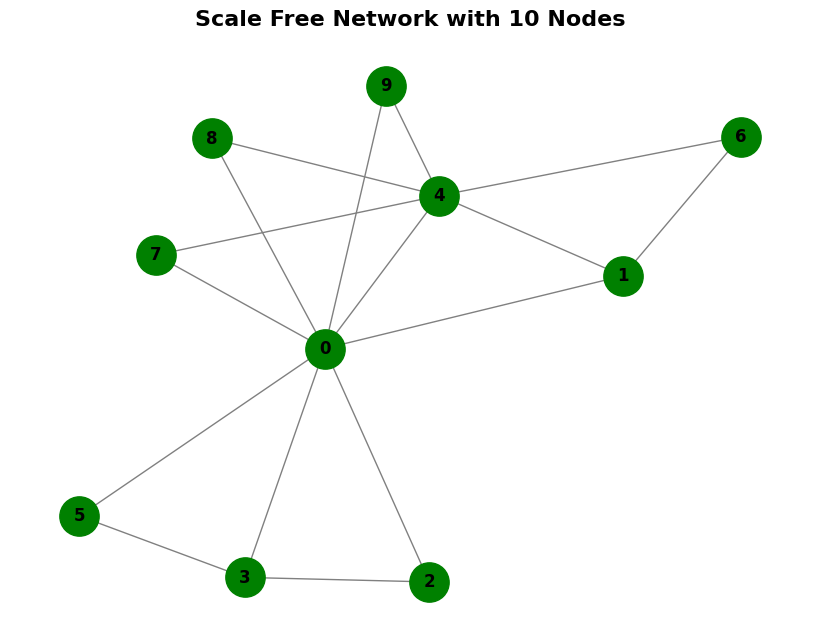

In [8]:
import networkx as nx
def create_scalefree_network(n_nodes, m=2, edge_weight=0.75):
  G = nx.barabasi_albert_graph(n_nodes, m) ## m portryaing the order for the no. of connections
  adj_matrix = nx.adjacency_matrix(G).todense()
  S = np.array(adj_matrix, dtype=float)
  S[S > 0] = edge_weight
  return S

n_nodes = 10
scalefree_adj = create_scalefree_network(n_nodes)
scalefree_graph = nx.from_numpy_array(scalefree_adj)

import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
pos = nx.spring_layout(scalefree_graph)
nx.draw(scalefree_graph,pos, with_labels=True, node_size=800, node_color='green',
        font_size=12, font_weight='bold', edge_color='gray')
plt.title(f"Scale Free Network with {n_nodes} Nodes", fontsize=16, fontweight='bold')
plt.savefig("scale_free_network.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
from torch_geometric.data import Dataset
import numpy as np
import torch

class ScaleFreeDataset(Dataset):
  def __init__(self, n_samples=1000, n_nodes=11, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_scalefree_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = []

    G = nx.from_numpy_array(self.adj_matrix)
    degree = np.array([deg for _,deg in G.degree()])
    hub_nodes = np.argsort(degree)[-2:] ## Top 2 hubs excluding the highest as index - 1
    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      ## Making the hubs nodes distinctive and scale-free specific
      for hub_idx in hub_nodes:
        features[:,hub_idx] += np.random.normal(2.0,1.0,n_features)
      n_modify = min(3,n_nodes)
      nodes_to_modify = np.random.choice(np.arange(n_nodes),size=n_modify,replace=False)

      hub_mean = np.mean(features[:,hub_nodes])
      non_hub_mean = np.mean(features[:,[i for i in range(n_nodes) if i not in hub_nodes]])
      label = int(abs(hub_mean - non_hub_mean) > 1.5)

      feature_magnitudes = np.linalg.norm(features, axis=0)
      squared = feature_magnitudes ** 2
      numerator = np.sum(squared** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numerator / denominator if denominator != 0 else 0.0

      ## Storing as torch tensors ##
      self.data.append(torch.tensor(features, dtype=torch.float64))
      self.labels.append(torch.tensor(label, dtype=torch.long))
      self.ipr_targets.append(ipr_value)


  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float64)

Using device: cpu
Initializing the ARMAfilter GNN ...
all the assertions passed
ARMAfilterGNN __init__ completed successfully
Model parameters: 30,561
Training ARMA model...
Epoch   0:Train Loss : 1.1659Cls1.1367, IPR: 0.0292) | Val Acc: 90.00% | Val IPR MAE: 0.0527
Epoch  10:Train Loss : 0.2366Cls0.2346, IPR: 0.0020) | Val Acc: 90.00% | Val IPR MAE: 0.0544
Epoch  20:Train Loss : 0.1580Cls0.1559, IPR: 0.0021) | Val Acc: 85.33% | Val IPR MAE: 0.0271
Epoch  30:Train Loss : 0.0800Cls0.0778, IPR: 0.0022) | Val Acc: 84.67% | Val IPR MAE: 0.0475
Epoch  40:Train Loss : 0.0396Cls0.0360, IPR: 0.0036) | Val Acc: 79.33% | Val IPR MAE: 0.0570

Evaluating on test set...

FINAL RESULTS

 CLASSIFICATION METRICS:
Accuracy: 0.9000
F1 Score: 0.8917
Precision: 0.8841
Recall: 0.9000

 IPR REGRESSION METRICS:
MAE: 0.0355
RMSE: 0.0445
R² Score: -0.3171
Correlation: 0.4382

Generating plots...


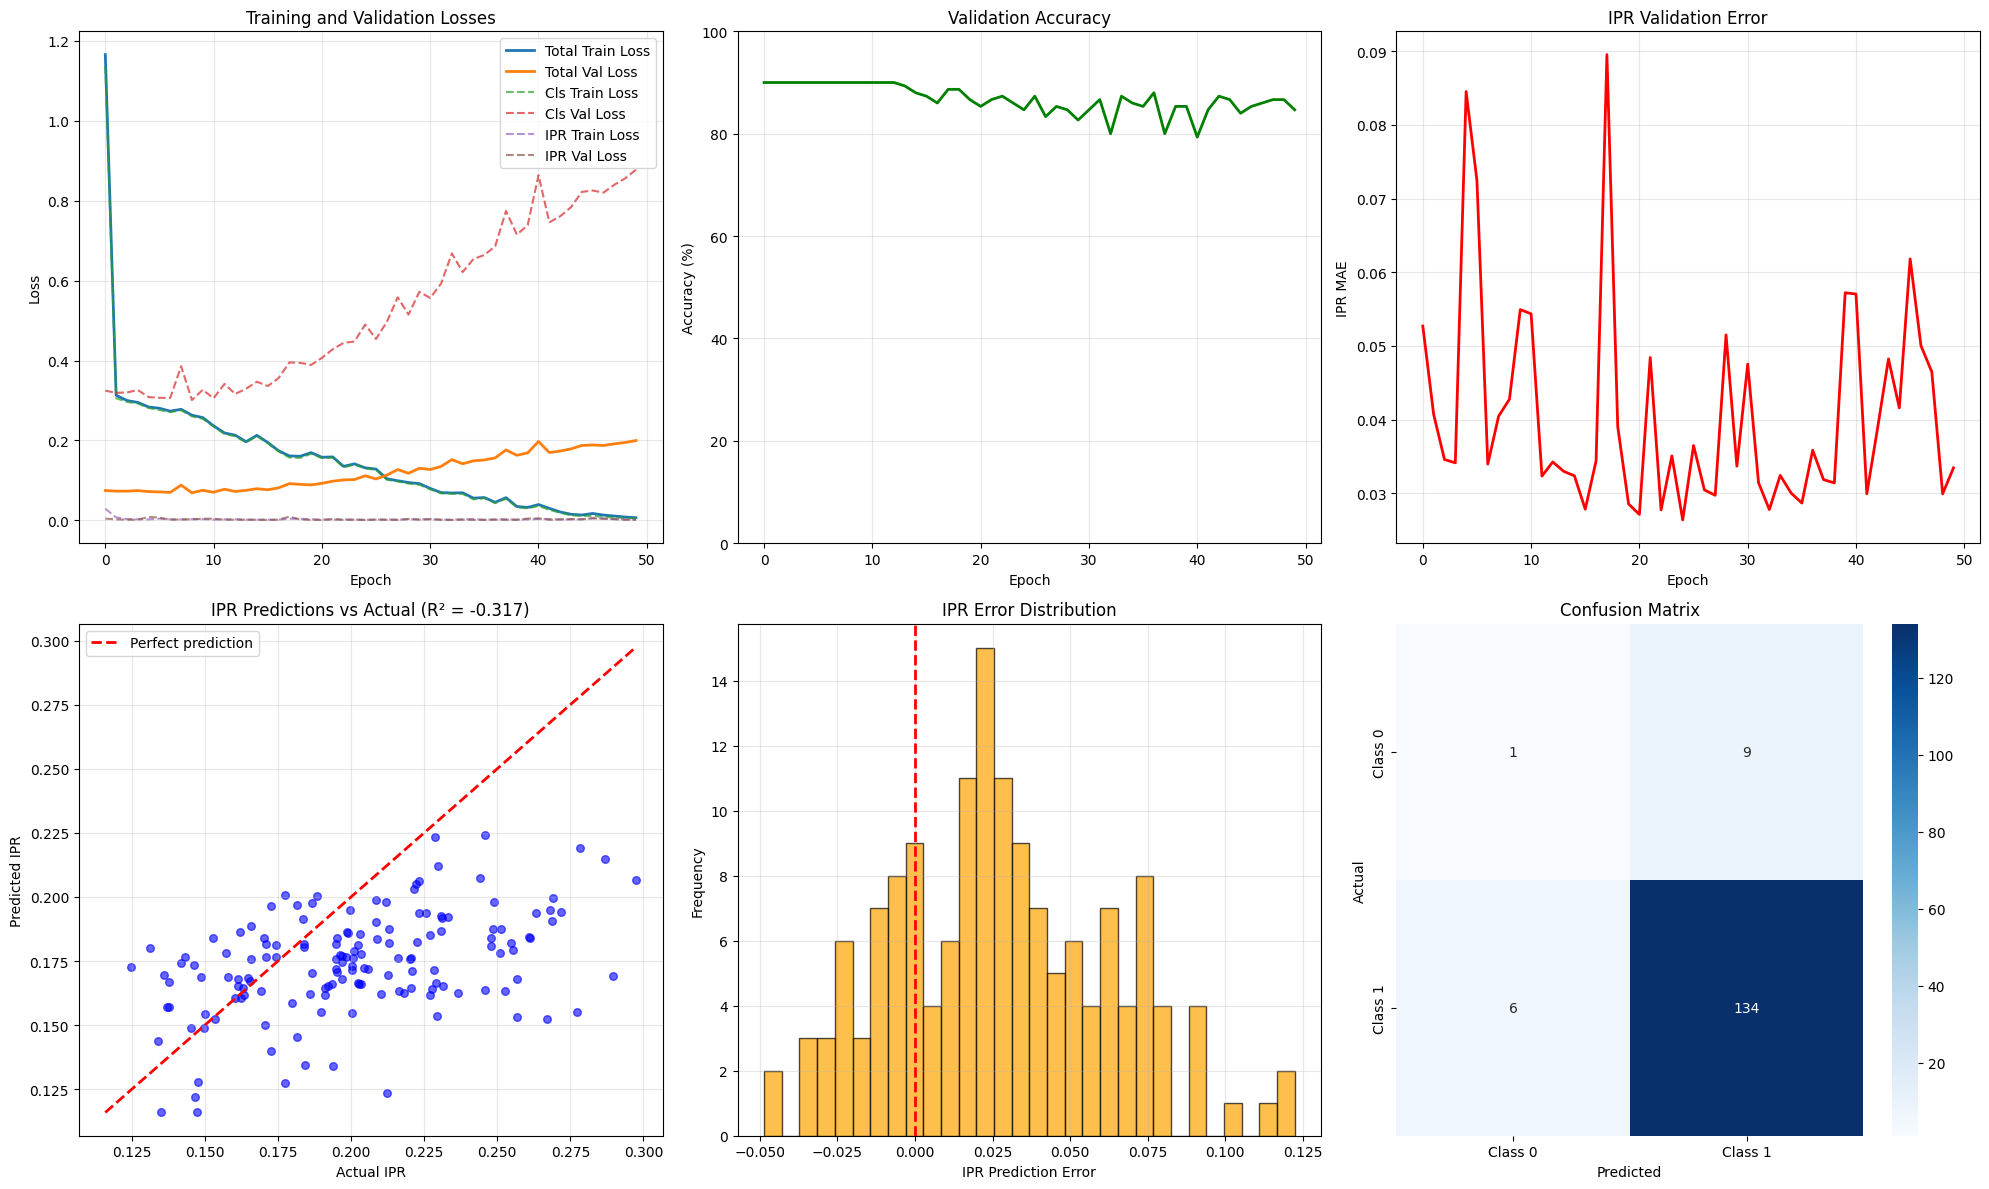


 DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.116, 0.224]
IPR actual range: [0.125, 0.297]
IPR error std: 0.0350

 Results saved to 'arma_model_Wheel_results.pth'
 Plot saved to 'arma_model_results_Wheel.png'


In [17]:
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Execution Block ##
if __name__ == "__main__":
  n_nodes = 11
  n_features = 8
  n_classes = 2
  n_samples = 1000
  batch_size = 32
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  dataset = ScaleFreeDataset(n_samples=n_samples, n_nodes=n_nodes,
                               n_features=n_features, n_classes=n_classes)
  train_size = int(0.7 * n_samples)
  val_size = int(0.15 * n_samples)
  test_size = n_samples - train_size - val_size

  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
      dataset, [train_size, val_size, test_size]
  )

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  adj_matrix = create_scalefree_network(n_nodes)
  model_config = {
    'dimNodeSignals': [n_features, 64, 32],
    'nDenominatorTaps': [2, 2],
    'nResidueTaps': [3, 3],
    'bias': True,
    'nonlinearity': nn.ReLU,
    'nSelectedNodes': [100, 50],
    'poolingFunction': None,  # You need to add this parameter
    'poolingSize': [2, 2],
    'dimLayersMLP': [128, 64],
    'GSO': adj_matrix,
    'order': 'Degree',
    'dimLayerIPR': [32, 16],  # Changed to singular to match class
    'tMax': 5
}

# Initialize model
model = ARMAfilterGNN(**model_config)
model = model.double()
model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss functions and optimizer
criterion_cls = nn.CrossEntropyLoss()
criterion_ipr = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
print("Training ARMA model...")
model = model.double()
train_losses, val_losses, val_accuracies, val_ipr_errors = train_arma_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_cls=criterion_cls,
    criterion_ipr=criterion_ipr,
    epochs=50,
    device=device,
    cls_weight=1.0,
    ipr_weight=0.8
)

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = evaluate_arma_model(
    model=model,
    test_loader=test_loader,
    device=device
)

# Print results
print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")

print(f"\n CLASSIFICATION METRICS:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1 Score: {test_results['f1_score']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")

print(f"\n IPR REGRESSION METRICS:")
print(f"MAE: {test_results['ipr_mae']:.4f}")
print(f"RMSE: {test_results['ipr_rmse']:.4f}")
print(f"R² Score: {test_results['ipr_r2']:.4f}")
print(f"Correlation: {test_results['ipr_correlation']:.4f}")

# Generate comprehensive plots
print("\nGenerating plots...")
plt.figure(figsize=(20, 12))

# Plot 1: Training and Validation Losses
plt.subplot(2, 3, 1)
plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(val_accuracies, 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Plot 3: IPR Validation Error
plt.subplot(2, 3, 3)
plt.plot(val_ipr_errors, 'r-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('IPR MAE')
plt.title('IPR Validation Error')
plt.grid(True, alpha=0.3)

# Plot 4: IPR Predictions vs Actual (Scatter)
plt.subplot(2, 3, 4)
plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
            alpha=0.6, s=30, c='blue')
min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual IPR')
plt.ylabel('Predicted IPR')
plt.title(f'IPR Predictions vs Actual (R² = {test_results["ipr_r2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: IPR Error Distribution
plt.subplot(2, 3, 5)
ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('IPR Prediction Error')
plt.ylabel('Frequency')
plt.title('IPR Error Distribution')
plt.grid(True, alpha=0.3)

# Plot 6: Confusion Matrix (Classification)
plt.subplot(2, 3, 6)
cm = confusion_matrix(test_results['labels'], test_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.savefig('arma_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed analysis
print(f"\n DETAILED ANALYSIS:")
print(f"Total samples: {test_results['total_samples']}")
print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
print(f"IPR error std: {np.std(ipr_errors):.4f}")

# Save results to file
results_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_ipr_errors': val_ipr_errors,
    'test_results': test_results,
    'model_config': model_config
}

torch.save({
    'model_state_dict': model.state_dict(),
    'results': results_dict
}, 'arma_model_results.pth')

print(f"\n Results saved to 'arma_model_Wheel_results.pth'")
print(f" Plot saved to 'arma_model_results_Wheel.png'")